In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import nltk
from tqdm import tqdm
import torchtext.data as data
import torch.optim as optim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torchtext.data import get_tokenizer
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import re

In [37]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
fake_df= pd.read_csv("/content/drive/MyDrive/gpt fakearticles/Fake.csv")
true_df = pd.read_csv("/content/drive/MyDrive/gpt fakearticles/True.csv")
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [39]:
true_df.shape
fake_df.shape

(23481, 4)

In [42]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [43]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [46]:
true_df['category'] = np.ones(len(true_df), dtype=int)
fake_df['category'] = np.zeros(len(fake_df), dtype=int)

true_df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [47]:
true_df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [48]:
true_df['class'] = 1
fake_df['class'] = 0

In [49]:
true_df.head()

,title,text,subject,date,category,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,1


<BarContainer object of 1 artists>

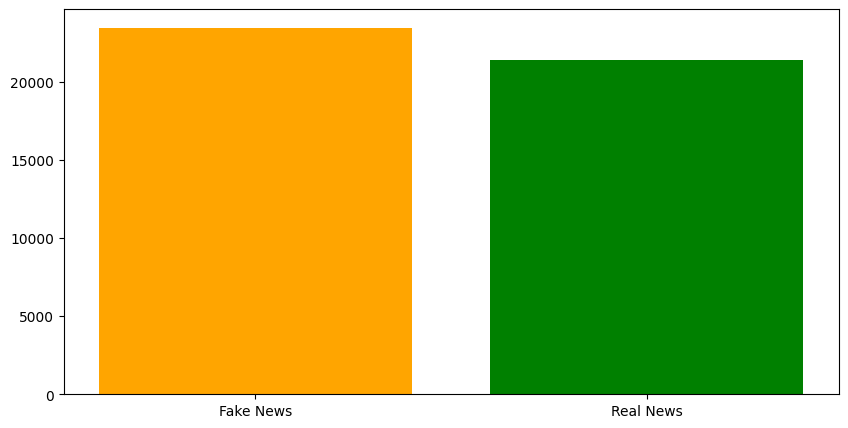

In [51]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(true_df), color='green')

In [52]:
# Difference of the Fake and Real News
print(f'Difference between Fake and Real News: {len(fake_df) - len(true_df)}')

Difference between Fake and Real News: 2064


In [53]:
news_df = pd.concat([true_df, fake_df], ignore_index=True, sort=False)
news_df

,title,text,subject,date,category,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,1
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,0


In [54]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
 5   class     44898 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


In [55]:
news_df.head()

,title,text,subject,date,category,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,1


In [56]:
news_df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [57]:
news_df = pd.get_dummies(news_df, columns=['subject'])
news_df.head()

,title,text,date,category,class,subject_Government News,subject_Middle-east,subject_News,subject_US_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,"December 31, 2017",1,1,0,0,0,0,0,0,1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,"December 29, 2017",1,1,0,0,0,0,0,0,1,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,"December 31, 2017",1,1,0,0,0,0,0,0,1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,"December 30, 2017",1,1,0,0,0,0,0,0,1,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,"December 29, 2017",1,1,0,0,0,0,0,0,1,0


In [58]:
news_df = news_df.drop('date', axis=1)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    44898 non-null  object
 1   text                     44898 non-null  object
 2   category                 44898 non-null  int64 
 3   class                    44898 non-null  int64 
 4   subject_Government News  44898 non-null  uint8 
 5   subject_Middle-east      44898 non-null  uint8 
 6   subject_News             44898 non-null  uint8 
 7   subject_US_News          44898 non-null  uint8 
 8   subject_left-news        44898 non-null  uint8 
 9   subject_politics         44898 non-null  uint8 
 10  subject_politicsNews     44898 non-null  uint8 
 11  subject_worldnews        44898 non-null  uint8 
dtypes: int64(2), object(2), uint8(8)
memory usage: 1.7+ MB


In [59]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [60]:
from nltk.corpus import wordnet

new_text = []
pattern = "[^a-zA-Z]"

lemma = nltk.WordNetLemmatizer()

for txt in tqdm(news_df.text):

    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_text.append(txt)

new_text[0]

100%|██████████| 44898/44898 [03:59<00:00, 187.84it/s]


'washington reuters the head of a conservative republican faction in the u s congress who voted this month for a huge expansion of the national debt to pay for tax cut called himself a fiscal conservative on sunday and urged budget restraint in in keeping with a sharp pivot under way among republican u s representative mark meadow speaking on cbs face the nation drew a hard line on federal spending which lawmaker are bracing to do battle over in january when they return from the holiday on wednesday lawmaker will begin trying to pas a federal budget in a fight likely to be linked to other issue such a immigration policy even a the november congressional election campaign approach in which republican will seek to keep control of congress president donald trump and his republican want a big budget increase in military spending while democrat also want proportional increase for non defense discretionary spending on program that support education scientific research infrastructure public h

In [62]:
new_title = []
for txt in tqdm(news_df.title):

    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    new_title.append(txt)
new_title[0]

100%|██████████| 44898/44898 [00:10<00:00, 4267.44it/s]


'a u s budget fight loom republican flip their fiscal script'

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_title = CountVectorizer(stop_words="english",max_features=1000)
vectorizer_text = CountVectorizer(stop_words="english",max_features=4000)

title_matrix = vectorizer_title.fit_transform(new_title).toarray()
text_matrix = vectorizer_text.fit_transform(new_text).toarray()

print("Finished")

Finished


In [64]:
news_df.head(5)

,title,text,category,class,subject_Government News,subject_Middle-east,subject_News,subject_US_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,1,0,0,0,0,0,0,1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,1,0,0,0,0,0,0,1,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,1,0,0,0,0,0,0,1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,1,0,0,0,0,0,0,1,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,1,0,0,0,0,0,0,1,0


In [65]:
news_df.drop(['title', 'text'], axis=1, inplace=True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   category                 44898 non-null  int64
 1   class                    44898 non-null  int64
 2   subject_Government News  44898 non-null  uint8
 3   subject_Middle-east      44898 non-null  uint8
 4   subject_News             44898 non-null  uint8
 5   subject_US_News          44898 non-null  uint8
 6   subject_left-news        44898 non-null  uint8
 7   subject_politics         44898 non-null  uint8
 8   subject_politicsNews     44898 non-null  uint8
 9   subject_worldnews        44898 non-null  uint8
dtypes: int64(2), uint8(8)
memory usage: 1.0 MB


In [66]:
print(news_df.shape)
print(title_matrix.shape)
print(text_matrix.shape)

(44898, 10)
(44898, 1000)
(44898, 4000)


In [67]:
X = np.concatenate((np.array(news_df.drop('category', axis=1)), title_matrix,
                     text_matrix), axis=1)
y = news_df.category

In [68]:
print(X.shape)
print(y.shape)

(44898, 5009)
(44898,)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33673, 5009)
(11225, 5009)
(33673,)
(11225,)


# BUILDING MODEL

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NewsClassifier(nn.Module):
    def __init__(self):
        super(NewsClassifier, self).__init__()

        # Fully connected layers
        self.linear1 = nn.Linear(5008, 2000)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2000, 500)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(500, 100)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.linear4 = nn.Linear(100, 20)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(20, 2)

    def forward(self, x):
        # Fully connected layers
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.dropout(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)

        return out

In [71]:
model = NewsClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.012)
criterion = nn.CrossEntropyLoss()

In [73]:
import torch.nn as nn

class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Adjust the input size to 5009
        self.layer1 = nn.Linear(5009, 2000)  # Example adjustment
        # ... add other layers as needed ...

    def forward(self, x):
        # Define the forward pass
        x = self.layer1(x)
        # ... pass through other layers as defined ...
        return x

# Instantiate the model
model = YourModel()


In [74]:
import torch
from tqdm import tqdm

# Assuming X_train, y_train, X_test, y_test are already defined and processed
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).type(torch.LongTensor)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30

for epoch in tqdm(range(EPOCHS)):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)

    # Calculate loss
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train).sum().item()
    accuracy = correct / len(y_train) * 100.0

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')


  3%|▎         | 1/30 [00:24<11:49, 24.46s/it]

Epoch [1/30], Loss: 7.5811, Accuracy: 0.05%


  7%|▋         | 2/30 [00:46<10:49, 23.20s/it]

Epoch [2/30], Loss: 7.2031, Accuracy: 15.12%


 10%|█         | 3/30 [01:10<10:29, 23.32s/it]

Epoch [3/30], Loss: 6.8284, Accuracy: 51.66%


 13%|█▎        | 4/30 [01:35<10:23, 23.96s/it]

Epoch [4/30], Loss: 6.4596, Accuracy: 59.10%


 17%|█▋        | 5/30 [01:59<09:58, 23.94s/it]

Epoch [5/30], Loss: 6.0975, Accuracy: 61.33%


 20%|██        | 6/30 [02:21<09:24, 23.51s/it]

Epoch [6/30], Loss: 5.7438, Accuracy: 62.75%


 23%|██▎       | 7/30 [02:43<08:44, 22.79s/it]

Epoch [7/30], Loss: 5.4010, Accuracy: 64.09%


 27%|██▋       | 8/30 [03:05<08:17, 22.64s/it]

Epoch [8/30], Loss: 5.0725, Accuracy: 65.53%


 30%|███       | 9/30 [03:28<08:00, 22.88s/it]

Epoch [9/30], Loss: 4.7611, Accuracy: 67.03%


 33%|███▎      | 10/30 [03:53<07:50, 23.53s/it]

Epoch [10/30], Loss: 4.4687, Accuracy: 68.84%


 37%|███▋      | 11/30 [04:17<07:30, 23.70s/it]

Epoch [11/30], Loss: 4.1963, Accuracy: 70.83%


 40%|████      | 12/30 [04:41<07:04, 23.57s/it]

Epoch [12/30], Loss: 3.9439, Accuracy: 72.99%


 43%|████▎     | 13/30 [05:03<06:32, 23.09s/it]

Epoch [13/30], Loss: 3.7109, Accuracy: 75.33%


 47%|████▋     | 14/30 [05:27<06:16, 23.52s/it]

Epoch [14/30], Loss: 3.4967, Accuracy: 77.93%


 50%|█████     | 15/30 [05:49<05:43, 22.90s/it]

Epoch [15/30], Loss: 3.3001, Accuracy: 80.43%


 53%|█████▎    | 16/30 [06:10<05:14, 22.46s/it]

Epoch [16/30], Loss: 3.1202, Accuracy: 82.95%


 57%|█████▋    | 17/30 [06:35<05:02, 23.24s/it]

Epoch [17/30], Loss: 2.9559, Accuracy: 85.33%


 60%|██████    | 18/30 [06:59<04:42, 23.55s/it]

Epoch [18/30], Loss: 2.8062, Accuracy: 87.28%


 63%|██████▎   | 19/30 [07:21<04:13, 23.04s/it]

Epoch [19/30], Loss: 2.6697, Accuracy: 89.12%


 67%|██████▋   | 20/30 [07:44<03:49, 22.96s/it]

Epoch [20/30], Loss: 2.5455, Accuracy: 90.73%


 70%|███████   | 21/30 [08:08<03:29, 23.33s/it]

Epoch [21/30], Loss: 2.4325, Accuracy: 92.01%


 73%|███████▎  | 22/30 [08:32<03:07, 23.47s/it]

Epoch [22/30], Loss: 2.3294, Accuracy: 92.98%


 77%|███████▋  | 23/30 [08:57<02:48, 24.04s/it]

Epoch [23/30], Loss: 2.2355, Accuracy: 93.79%


 80%|████████  | 24/30 [09:19<02:20, 23.46s/it]

Epoch [24/30], Loss: 2.1497, Accuracy: 94.39%


 83%|████████▎ | 25/30 [09:42<01:55, 23.04s/it]

Epoch [25/30], Loss: 2.0712, Accuracy: 94.89%


 87%|████████▋ | 26/30 [10:07<01:34, 23.66s/it]

Epoch [26/30], Loss: 1.9992, Accuracy: 95.36%


 90%|█████████ | 27/30 [10:29<01:09, 23.20s/it]

Epoch [27/30], Loss: 1.9332, Accuracy: 95.71%


 93%|█████████▎| 28/30 [10:52<00:46, 23.26s/it]

Epoch [28/30], Loss: 1.8724, Accuracy: 95.95%


 97%|█████████▋| 29/30 [11:18<00:24, 24.14s/it]

Epoch [29/30], Loss: 1.8163, Accuracy: 96.16%


100%|██████████| 30/30 [11:42<00:00, 23.41s/it]

Epoch [30/30], Loss: 1.7645, Accuracy: 96.35%


In [75]:
#Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    correct = (predicted == y_test).sum().item()
    test_accuracy = correct / len(y_test) * 100.0
    test_loss = criterion(test_outputs, y_test)

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.2f}%')

Test Accuracy: 96.45%
Test Loss: 1.71%
